# Restricted Boltzman Machine (RBM), no tears

In [1]:
%%html
<svg height="300" width="600">
    <!-- arcs from hidden unit 1 to visible units -->
    <line x1="160" y1="50" x2="40" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="120" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="200" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="280" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="360" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="440" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    
    <!-- arcs from hidden unit 2 to visible units -->
    <line x1="320" y1="50" x2="40" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="120" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="200" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="280" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="360" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="440" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    
    <line x1="540" y1="120" x2="160" y2="50" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="320" y2="50" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="40" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="120" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="200" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="280" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="360" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="440" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    
    <!-- hidden units -->
    <circle cx="160" cy="50" r="20" stroke="red" stroke-width="2" fill="white" />
    <circle cx="320" cy="50" r="20" stroke="red" stroke-width="2" fill="white" />
    
    <text x="154" y="55"><tspan>h<tspan dy="5">1</tspan></tspan></text>
    <text x="314" y="55"><tspan>h<tspan dy="5">2</tspan></tspan></text>
    
    <!-- visible units-->
    <circle cx="40" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="120" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="200" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="280" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="360" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="440" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    
    <text x="34" y="200"><tspan>v<tspan dy="5">1</tspan></tspan></text>
    <text x="114" y="200"><tspan>v<tspan dy="5">2</tspan></tspan></text>
    <text x="194" y="200"><tspan>v<tspan dy="5">3</tspan></tspan></text>
    <text x="274" y="200"><tspan>v<tspan dy="5">4</tspan></tspan></text>
    <text x="354" y="200"><tspan>v<tspan dy="5">5</tspan></tspan></text>
    <text x="434" y="200"><tspan>v<tspan dy="5">6</tspan></tspan></text>
    
    <!-- bias unit -->
    <circle cx="540" cy="120" r="20" stroke="black" stroke-width="2" fill="white" />
    <text x="535" y="123"><tspan>b</tspan></text>
</svg> 

In [2]:
%matplotlib inline
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

np.random.seed(37)    

In [3]:
def get_weight_matrix(n_visible, n_hidden, mean=0.0, stdev=0.1):
    w = np.random.normal(loc=mean, scale=stdev, size=n_visible * n_hidden).reshape(n_visible, n_hidden)
    c = np.zeros((n_visible, 1))
    r = np.zeros((1, n_hidden + 1))
    m = np.hstack([c, w])
    m = np.vstack([r, m])
    return m

def get_data_matrix(data):
    c = np.ones((data.shape[0], 1))
    m = np.hstack([c, data])
    return m

def positive_contrastive_divergence(X, W):
    ph_activations = X.dot(W)
    ph_probs = expit(ph_activations)
    ph_probs[:, 0] = 1.0
    ph_states = ph_probs > np.random.rand(ph_probs.shape[1])
    p_associations = X.T.dot(ph_probs)
    return ph_states, p_associations

def negative_contrastive_divergence(ph_states, W):
    nv_activations = ph_states.dot(W.T)
    nv_probs = expit(nv_activations)
    nv_probs[:, 0] = 1.0
    nh_activations = nv_probs.dot(W)
    nh_probs = expit(nh_activations)
    n_associations = nv_probs.T.dot(nh_probs)
    return nv_probs, n_associations

def update_weights(n, p_associations, n_associations, W, lr=0.1):
    M = W + lr * ((p_associations - n_associations) / float(n))
    return M

def query_hidden(v, n_hidden, W):
    n = v.shape[0]
    h_states = np.ones((n, n_hidden + 1))
    d = np.hstack([np.ones((n, 1)), v])
    h_activations = d.dot(W)
    h_probs = expit(h_activations)
    h_states[:,:] = h_probs > np.random.rand(n, n_hidden + 1)
    return h_states[:,1:]

def query_visible(h, n_visible, W):
    n = h.shape[0]
    v_states = np.ones((n, n_visible + 1))
    d = np.hstack([np.ones((n, 1)), h])
    v_activations = d.dot(W.T)
    v_probs = expit(v_activations)
    v_states[:,:] = v_probs > np.random.rand(n, n_visible + 1)
    return v_states[:,1:]

def daydream(n_samples, n_visible, n_hidden, W):
    samples = np.ones((n_samples, n_visible + 1))
    samples[0,1:] = np.random.rand(n_visible)
    
    for i in range(1, n_samples):
        visible = samples[i-1,:]
        h_activations = visible.dot(W)
        h_probs = expit(h_activations)
        h_states = h_probs > np.random.rand(n_hidden + 1)
        h_states[0] = 1
        
        v_activations = h_states.dot(W.T)
        v_probs = expit(v_activations)
        v_states = v_probs > np.random.rand(n_visible + 1)
        
        samples[i, :] = v_states
    
    return samples[-1, :]

def train(X, W, max_iters=100, batch_size=1, shuffle=True):
    b_size = batch_size
    if b_size < 1:
        b_size = 1
    if b_size > X.shape[0]:
        b_size = X.shape
    
    loss_trace = []
    for epoch in tqdm(range(max_iters)):
        S = np.copy(X)
        if shuffle is True:
            np.random.shuffle(S)
        start = 0
        while True:
            stop = start + b_size
            X_batch = S[start:stop, :]
            ph_states, p_associations = positive_contrastive_divergence(X_batch, W)
            nv_probs, n_associations = negative_contrastive_divergence(ph_states, W)
            W = update_weights(X.shape[0], p_associations, n_associations, W)

            error = np.sum((X_batch - nv_probs) ** 2) / float(b_size)
            t = (epoch, error)
            loss_trace.append(t)
            
            start = start + b_size
            if start >= X.shape[0]:
                break
                
    loss_df = pd.DataFrame(data=loss_trace, columns=['epoch', 'loss'])
    return W, loss_df

def plot_loss(loss):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(loss['epoch'], loss['loss'])
    ax.set_title('Loss over time')
    ax.set_xlabel(r'epoch')
    ax.set_ylabel(r'loss')

# Fake movies

In [4]:
X = get_data_matrix(np.array([
    [1, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 0]]))

In [5]:
n_visible = 6
n_hidden = 2
W = get_weight_matrix(n_visible, n_hidden)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4545.44it/s]


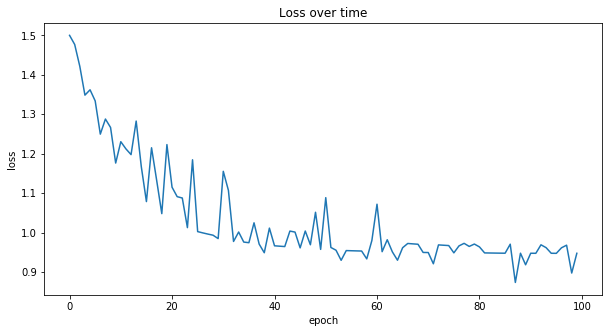

In [6]:
W, loss = train(X, W, batch_size=X.shape[0], shuffle=False)
plot_loss(loss)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1886.79it/s]


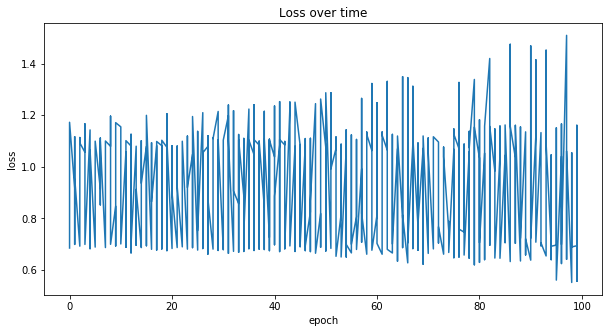

In [7]:
W, loss = train(X, W, batch_size=1, shuffle=True)
plot_loss(loss)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3225.79it/s]


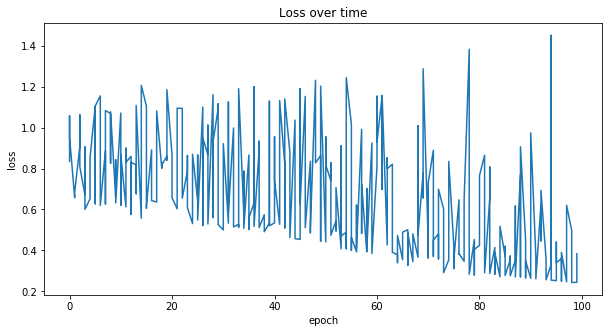

In [8]:
W, loss = train(X, W, batch_size=2, shuffle=True)
plot_loss(loss)

In [9]:
query_hidden(np.array([[0, 0, 0, 1, 1, 0]]), n_hidden, W)

array([[1., 0.]])

In [10]:
query_hidden(np.array([[1, 1, 0, 0, 0, 0]]), n_hidden, W)

array([[0., 1.]])

In [11]:
query_visible(np.array([[1, 0]]), n_visible, W)

array([[0., 0., 1., 0., 1., 0.]])

In [12]:
query_visible(np.array([[0, 1]]), n_visible, W)

array([[1., 0., 1., 0., 1., 0.]])

In [13]:
for i in range(10):
    print(daydream(500, n_visible, n_hidden, W))

[1. 1. 0. 1. 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 0.]
[0. 0. 0. 1. 1. 1. 0.]
[0. 0. 1. 1. 0. 0. 0.]
[1. 1. 0. 1. 1. 0. 0.]
[1. 1. 0. 1. 0. 0. 0.]
[1. 0. 0. 1. 0. 0. 0.]
[1. 1. 0. 1. 0. 0. 0.]
[1. 0. 1. 1. 1. 1. 0.]
[1. 0. 0. 1. 1. 0. 0.]


# Popular English, Chinese, and Indian Names

In [14]:
import itertools

def get_max_length(names):
    max_length = 0
    for k, v in names.iteritems():
        length = max([len(name) for name in v])
        if length > max_length:
            max_length = length
    return max_length

def get_encoding():
    letters = 'abcdefghijklmnopqrstuvwxyz#'
    d = {}
    for i in range(len(letters)):
        d[letters[i]] = i
    return d

def get_reverse_encoding():
    letters = 'abcdefghijklmnopqrstuvwxyz#'
    d = {}
    for i in range(len(letters)):
        d[i] = letters[i]
    return d

def encode_letter(letter, encoding=get_encoding()):
    n = len(encoding)
    ohe = np.zeros(n)
    idx = encoding[letter]
    ohe[idx] = 1
    return ohe

def encode_name(name, max_letters, encoding=get_encoding()):
    name_length = len(name)
    name_ohe = [encode_letter(name[i], encoding) for i in range(name_length)]
    padd_ohe = [encode_letter('#', encoding) for _ in range(name_length, max_letters)]
    
    ohe = []
    ohe.extend(name_ohe)
    ohe.extend(padd_ohe)
    ohe = np.hstack(ohe)
    
    return ohe

def encode_names(names, max_letters, encoding=get_encoding()):
    data = []
    for k, names in names.iteritems():
        for name in names:
            ohe = encode_name(name, max_letters, encoding)
            data.append(ohe)
    return np.array(data)

def flatten_names(names):
    data = []
    for k, names in names.iteritems():
        data.extend(names)
    return data

def decode_ohe(v, max_letters, encoding=get_reverse_encoding()):
    def encode(row, vector, encoding):
        codes = [encoding[i] for i, c in enumerate(vector[row, :]) if c > 0 and i < 26]
        out = ''.join(codes).strip()
        if len(out) == 0:
            return None
        else:
            return out
    
    vector = v[0,:]
    cols = v.shape[1] / max_letters
    rows = max_letters
    vector = vector.reshape(rows, cols)
    d = []
    for i, row in enumerate(range(rows)):
        v_activations = encode(row, vector, encoding)
        if v_activations is not None and len(v_activations) > 0:
            d.append(v_activations)
    return d

def get_combinations(decoding):
    return [''.join(t) for t in list(itertools.product(*decoding))]
    
names = {
    'english': [
        'jack', 'thomas', 'joshua', 'william', 'daniel',
        'matthew', 'james', 'joseph', 'harry', 'samuel'
    ],
    'chinese': [
        'wei', 'qiang', 'lei', 'jun', 'yong',
        'jie', 'jin', 'taio', 'de', 'tao'
    ],
    'indian': [
        'mohammed', 'reyansh', 'aarav', 'atharv', 'vivaan',
        'advik', 'ansh', 'ishann', 'dhruv', 'siddharth'
    ]
}

max_letters = get_max_length(names)
encoding = get_encoding()
rencoding = get_reverse_encoding()
raw = encode_names(names, max_letters, encoding)

In [15]:
X = get_data_matrix(raw)
print('{} X shape'.format(X.shape))

n_visible = raw.shape[1]
n_hidden = 3
W = get_weight_matrix(n_visible, n_hidden)
print('{} W shape'.format(W.shape))
print('{} n_visible'.format(n_visible))
print('{} n_hidden'.format(n_hidden))

(30L, 244L) X shape
(244L, 4L) W shape
243 n_visible
3 n_hidden


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1851.86it/s]


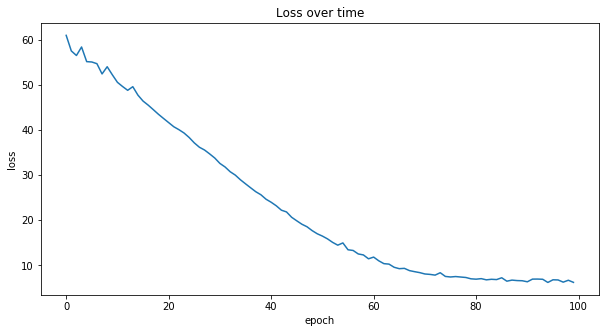

In [16]:
W, loss = train(X, W, batch_size=X.shape[0], shuffle=False)
plot_loss(loss)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 453.51it/s]


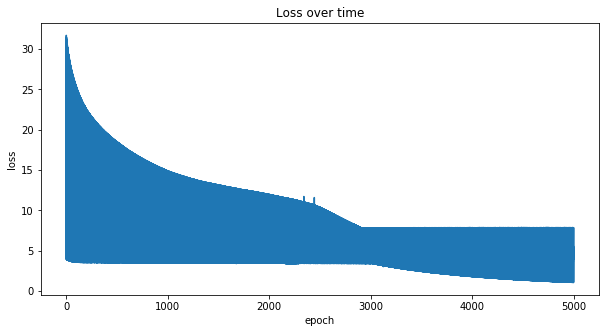

In [17]:
W, loss = train(X, W, max_iters=5000, batch_size=1, shuffle=True)
plot_loss(loss)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 756.66it/s]


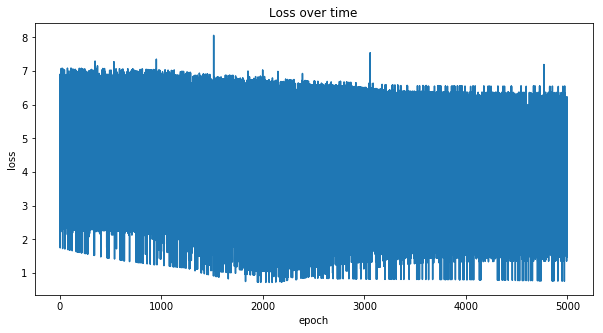

In [18]:
W, loss = train(X, W, max_iters=5000, batch_size=2, shuffle=True)
plot_loss(loss)

In [19]:
flattened_names = flatten_names(names)

for r in range(len(raw)):
    h = query_hidden(raw[r,:].reshape(1, n_visible), n_hidden, W)
    n = flattened_names[r]
    print('{}: {} {}'.format(r, h, n))

0: [[1. 0. 1.]] mohammed
1: [[1. 1. 1.]] reyansh
2: [[1. 1. 1.]] aarav
3: [[1. 1. 1.]] atharv
4: [[1. 1. 1.]] vivaan
5: [[1. 1. 1.]] advik
6: [[1. 1. 1.]] ansh
7: [[1. 1. 1.]] ishann
8: [[1. 1. 1.]] dhruv
9: [[0. 0. 0.]] siddharth
10: [[1. 1. 0.]] wei
11: [[1. 1. 1.]] qiang
12: [[1. 1. 0.]] lei
13: [[1. 1. 0.]] jun
14: [[1. 1. 0.]] yong
15: [[1. 1. 0.]] jie
16: [[1. 1. 0.]] jin
17: [[1. 1. 0.]] taio
18: [[1. 1. 0.]] de
19: [[1. 1. 0.]] tao
20: [[1. 1. 0.]] jack
21: [[1. 1. 1.]] thomas
22: [[1. 1. 1.]] joshua
23: [[0. 1. 1.]] william
24: [[1. 1. 1.]] daniel
25: [[1. 0. 1.]] matthew
26: [[1. 1. 1.]] james
27: [[1. 1. 1.]] joseph
28: [[1. 1. 1.]] harry
29: [[1. 1. 1.]] samuel


In [20]:
', '.join(get_combinations(
    decode_ohe(
        query_visible(np.array([[0, 1, 1]]), n_visible, W), max_letters, rencoding)))

'wileiam, wiluiam'

In [26]:
', '.join(get_combinations(
    decode_ohe(
        query_visible(np.array([[1, 1, 0]]), n_visible, W), max_letters, rencoding)))

'tee, ten'

In [30]:
', '.join(get_combinations(
    decode_ohe(
        query_visible(np.array([[1, 0, 1]]), n_visible, W), max_letters, rencoding)))

'mahamee, mahamew, maramee, maramew, matamee, matamew'

In [23]:
for i in range(5):
    dd = daydream(5000, n_visible, n_hidden, W)
    dd = dd.reshape(1, dd.shape[0])
    dd = dd[:,1:]
    dd = get_combinations(decode_ohe(dd, max_letters, rencoding))
    dd = ', '.join(dd)
    print('daydream iteration {}'.format(i + 1))
    print(dd)
    print('')

daydream iteration 1
baddearqh, baddearth, baddeerqh, baddeerth, baddharqh, baddharth, baddherqh, baddherth, baddrarqh, baddrarth, baddrerqh, baddrerth, badeearqh, badeearth, badeeerqh, badeeerth, badeharqh, badeharth, badeherqh, badeherth, baderarqh, baderarth, badererqh, badererth, biddearqh, biddearth, biddeerqh, biddeerth, biddharqh, biddharth, biddherqh, biddherth, biddrarqh, biddrarth, biddrerqh, biddrerth, bideearqh, bideearth, bideeerqh, bideeerth, bideharqh, bideharth, bideherqh, bideherth, biderarqh, biderarth, bidererqh, bidererth, saddearqh, saddearth, saddeerqh, saddeerth, saddharqh, saddharth, saddherqh, saddherth, saddrarqh, saddrarth, saddrerqh, saddrerth, sadeearqh, sadeearth, sadeeerqh, sadeeerth, sadeharqh, sadeharth, sadeherqh, sadeherth, saderarqh, saderarth, sadererqh, sadererth, siddearqh, siddearth, siddeerqh, siddeerth, siddharqh, siddharth, siddherqh, siddherth, siddrarqh, siddrarth, siddrerqh, siddrerth, sideearqh, sideearth, sideeerqh, sideeerth, sideharqh, 

# References

* [Introduction to Restricted Boltzmann Machines](http://blog.echen.me/2011/07/18/introduction-to-restricted-boltzmann-machines/)
* [Dreaming of names with RBMs](http://colinmorris.github.io/blog/dreaming-rbms)
* [A Practical guide to training restricted Boltzmann machines](http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
* [Geometry of the Restricted Boltzmann Machine](http://arxiv.org/abs/0908.4425)
* [Top 100 boy names in India 2017](https://www.babycenter.in/a25024464/top-100-boy-names-in-india-in-2017)
* [The most popular names in China](http://www.theworldofchinese.com/2014/07/the-most-popular-names-in-china-not-a-john-smith-in-sight/)
* [Most Popular Chinese Baby Boy Names ](https://www.mom365.com/baby-names/chinese-boys-names)
* [The 10 Most Popular Babies' Names from English Speaking Countries](http://www.world-english.org/boys_names.htm)
* [How to generate all permutations of a list in Python](https://stackoverflow.com/questions/104420/how-to-generate-all-permutations-of-a-list-in-python)